# Set-up

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

import datetime
import glob
import ipdb
import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')  # https://matplotlib.org/users/style_sheets.html
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import os
import pandas as pd
from pandas.plotting import scatter_matrix
import plotnine as gg
gg.theme_set(gg.theme_bw)
from scipy import stats
from sklearn import manifold, decomposition, preprocessing
import seaborn as sns
import time

from AlienTask import Task
from shared_aliens import get_alien_paths, read_in_human_data
# update_Qs_sim, get_alien_paths, get_alien_initial_q,\
#     get_summary_initial_learn, get_summary_cloudy, simulate_competition_phase, simulate_rainbow_phase, get_summary_rainbow,\
#     read_in_human_data, get_chosen_TS
from SimulateAliensJupyterVersionFunctions import *

## Paths

In [2]:
# Data paths
## Where is human experimental data stored?
human_data_path = get_alien_paths()["human data prepr"]

## Where will simulated summaries be saved or read in?
summary_save_dir = os.path.join(get_alien_paths()['fitting results'], 'Summaries')
full_summary_save_dir = os.path.join(summary_save_dir, 'FullSimulations')

## Where will plots be saved that we create here?
plot_save_dir = os.path.join(summary_save_dir, 'plots')  # 'C:/Users/maria/MEGAsync/Berkeley/TaskSets/paperplots/'

## Initialize task object

In [3]:
# Create task, get numbers of trials for each phase
task = Task(n_subj)
n_trials, _, _, _, _ = task.get_trial_sequence(get_alien_paths()["human data prepr"],
                                         n_subj, n_sim_per_subj, range(n_subj),
                                         phases=("1InitialLearning", "2CloudySeason"))

n_trials_ = {'1InitialLearn': np.sum(task.phase == '1InitialLearning'),
             '2CloudySeason': np.sum(task.phase == '2CloudySeason'),
             '4RainbowSeason': 4 * n_aliens,
             '5Competition': 3}

trials = {'1InitialLearn': range(n_trials_['1InitialLearn']),
          '2CloudySeason': range(n_trials_['1InitialLearn'],
                                 n_trials_['1InitialLearn'] + n_trials_['2CloudySeason'])}

# Analyze all simulations: Density plots

## Read in human data

In [4]:
# Get human raw data
n_hum, hum_aliens, hum_seasons, hum_corrects, hum_actions, hum_rewards, hum_rainbow_dat, hum_comp_dat = read_in_human_data(
    human_data_path, 828, n_aliens, n_actions, exclude=['160',])  # '164' -> already excluded for head trauma

# Calculate human summaries
(hum_summary_initial_learn, hum_summary_cloudy, hum_summary_competition,
hum_summary_rainbow, hum_regr_coefs) = get_human_summaries(
    n_hum, hum_aliens, hum_seasons, hum_corrects, hum_actions,
    hum_rewards, hum_rainbow_dat, hum_comp_dat, trials, task, n_seasons)

Reading in human data from C:/Users/maria/MEGAsync/Berkeley/TaskSets/Data/version3.1preprocessed/!
1 subjects were exlcuded: ['160']


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


## Read in simulated data

In [5]:
# Read in all csv with summaries
filenames = glob.glob(os.path.join(summary_save_dir, '*.csv'))
filenames = [filename for filename in filenames if 'summar' in filename]  # don't read in selected_agents.csv etc.
print('Found {} files.'.format(len(filenames)))

all_summaries = read_in_all_summaries(filenames)
print("Number of samples: {} (flat: {}; hier: {}; Bayes: {})".
      format(all_summaries.shape[0],
             np.sum(all_summaries['model'] == 'flat'),
             np.sum(all_summaries['model'] == 'hier'),
             np.sum(all_summaries['model'] == 'Bayes')
))

Found 151 files.
Number of samples: 150001 (flat: 50000; hier: 50000; Bayes: 50001)


In [6]:
# Get rainbow summary
summary_rainbow = pd.DataFrame()
for model in models:
    rainbow_dat = all_summaries.loc[all_summaries['model'] == model, RB_cols]
    rainbow_dat = rainbow_dat.values.reshape((rainbow_dat.shape[0], n_aliens, n_actions))
    
    summary_rainbow_mod = np.array([get_summary_rainbow(n_aliens, n_seasons, dat, task) for dat in rainbow_dat])
    summary_rainbow_mod = pd.DataFrame(summary_rainbow_mod, columns=RB_sum_cols)
    summary_rainbow_mod.loc[:, 'model'] = model
    
    cor = np.array([np.corrcoef(hum_rainbow_dat[0].flatten(), dat.flatten())[0, 1] for dat in rainbow_dat.astype(float)])
    summary_rainbow_mod.loc[:, 'corr_with_humans'] = cor
    
    summary_rainbow = summary_rainbow.append(summary_rainbow_mod)
    
summary_rainbow['TS0_minus_TS1'] = summary_rainbow['TS0'] - summary_rainbow['TS1']
summary_rainbow['TS0_minus_TS2'] = summary_rainbow['TS0'] - summary_rainbow['TS2']
summary_rainbow['TS1_minus_TS2'] = summary_rainbow['TS1'] - summary_rainbow['TS2']
summary_rainbow.head()

,TS0,TS1,TS2,None,TS0_se,TS1_se,TS2_se,None_se,model,corr_with_humans,TS0_minus_TS1,TS0_minus_TS2,TS1_minus_TS2
0,0.385538,0.331544,0.275841,0.127879,0.0,0.0,0.0,0.0,hier,0.808513,0.053994,0.109697,0.055703
1,0.339648,0.333759,0.328335,0.163967,0.0,0.0,0.0,0.0,hier,0.247158,0.005889,0.011314,0.005424
2,0.477368,0.307522,0.200494,0.084964,0.0,0.0,0.0,0.0,hier,0.717392,0.169846,0.276873,0.107028
3,0.334727,0.334340,0.328456,0.164726,0.0,0.0,0.0,0.0,hier,0.766471,0.000387,0.006271,0.005884
4,0.404164,0.368147,0.200581,0.090238,0.0,0.0,0.0,0.0,hier,0.731063,0.036017,0.203582,0.167565


## Plot simulated parameters

In [7]:
# # Plot correlations and histograms
# for model_name in models:
#     model_summaries = all_summaries.loc[all_summaries['model'] == model_name]
#     model_summaries = model_summaries.reset_index(drop=True)
#     pd.plotting.scatter_matrix(model_summaries.loc[:1000, ['alpha', 'beta', 'forget']])

## Plot histograms

### Functions

In [8]:
def get_means_sds(sim_dat, hum_dat, column, t_compare_value=0):
    
    means_sds = sim_dat.groupby("model")[column].agg(
        {'mean': 'mean',
         'std': 'std',
         'lik': lambda x: np.mean(x > hum_dat[column][0]),
         'lik2': lambda x: np.mean(x < hum_dat[column][0])})
    
    ttests = sim_dat.groupby('model')[column].agg(stats.ttest_1samp, t_compare_value)
    
    return means_sds, ttests

In [9]:
def get_difference_data(dat1, dat2, n_bins=50):
    
    dat_both = np.append(dat1, dat2)
    
    min_bin, max_bin = min(dat_both), max(dat_both)
    
    hist1, bins1 = np.histogram(dat1, range=(min_bin, max_bin), bins=n_bins)
    hist2, bins2 = np.histogram(dat2, range=(min_bin, max_bin), bins=n_bins)
    assert np.all(bins1 == bins2)
    
    diff = hist2 - hist1
    
    diff_dat = pd.DataFrame({'diff': diff,
                             'bin': bins1[:-1]})

    return diff_dat

# Example usage
nbins = 50
phase = '1InitialLearn'

dat_flat = all_summaries.loc[all_summaries.model=='flat', 'Qts_{}_mean'.format(phase)].values
dat_hier = all_summaries.loc[all_summaries.model=='hier', 'Qts_{}_mean'.format(phase)].values

get_difference_data(dat_flat, dat_hier)

,diff,bin
0,1,-0.375913
1,1,-0.359640
2,1,-0.343368
3,0,-0.327095
4,0,-0.310822
5,0,-0.294549
6,3,-0.278276
7,1,-0.262003
8,6,-0.245730
9,4,-0.229457


In [10]:
# Reusable histogram function for all histogram plots
def make_histogram(sim_dat, hum_dat, col_name, figure_size=(6, 2),
                   xlim=None, ylim=None, vline=0, plot_name='test.png'):
    
    gg.options.figure_size = figure_size
    g = (gg.ggplot(sim_dat, gg.aes(col_name, color='model'))
     + gg.geom_density()
     + gg.xlab(col_name)
     + gg.scale_color_manual(['green', 'orange', 'blue'])
     + gg.geom_vline(xintercept=hum_dat[col_name], color='red')
     + gg.geom_vline(xintercept=vline, linetype='dotted')
     + gg.coord_cartesian(xlim=xlim, ylim=ylim)
    )
    save_path = os.path.join(plot_save_dir, plot_name)
    print("Saving to {}.".format(save_path))
    g.draw()
    g.save(save_path)

# Example use
plot_name_base = '0TS_react_hist'
# make_histogram(all_summaries, hum_summary_cloudy, CL_cols[8], xlim=(-0.1, 0.25))

In [11]:
def make_diff_hist(sim_dat, hum_dat, col_name, model_names, figure_size = (4, 3),
                   plot_name='test.png', n_bins=40, vline=0, xlim=None, ylim=None):

    all_diff_dat = pd.DataFrame()

    for model1_name, model2_name in model_names:
        dat1 = sim_dat.loc[sim_dat.model==model1_name, col_name].values
        dat2 = sim_dat.loc[sim_dat.model==model2_name, col_name].values

        diff_dat = get_difference_data(dat1, dat2, n_bins=n_bins)
        diff_dat['measure'] = col_name
        diff_dat['models'] = ' minus '.join([model2_name, model1_name])

        all_diff_dat = all_diff_dat.append(diff_dat)

    gg.options.figure_size = figure_size
    g = (gg.ggplot(all_diff_dat, gg.aes('bin', 'diff', color='models'))
     + gg.geom_line()
     + gg.xlab(col_name)
     + gg.ylab('Difference (# samples)')
     + gg.scale_color_manual(['green', 'orange'])
     + gg.geom_vline(xintercept=hum_dat[col_name], color='red')
     + gg.geom_vline(xintercept=vline, linetype='dotted')
     + gg.coord_cartesian(xlim=xlim, ylim=ylim)
    )
    save_path = os.path.join(plot_save_dir, plot_name)
    print("Saving to {}.".format(save_path))
    g.draw()
    g.save(save_path)
    
# Example use
model_names = [['flat', 'hier'], ['Bayes', 'hier']]
col_name = 'Qts_1InitialLearn_mean'
# make_diff_hist(all_summaries, hum_regr_coefs, col_name, model_names, xlim=(-0.3, 0.3))

### Make the histograms

Saving to C:/Users/maria/MEGAsync/Berkeley/TaskSets/models\Summaries\plots\2TS_values_regression_Qts_1InitialLearn_mean_hist.png.


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 6 x 2 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/Berkeley/TaskSets/models\Summaries\plots\2TS_values_regression_Qts_1InitialLearn_mean_hist.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


Saving to C:/Users/maria/MEGAsync/Berkeley/TaskSets/models\Summaries\plots\2TS_values_regression_Qa_1InitialLearn_mean_hist.png.


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 6 x 2 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/Berkeley/TaskSets/models\Summaries\plots\2TS_values_regression_Qa_1InitialLearn_mean_hist.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


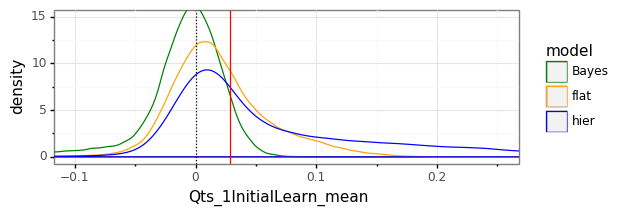

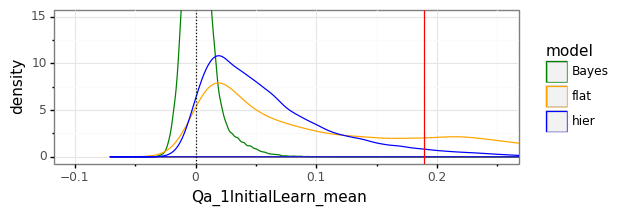

In [12]:
# Which TS are used initially (first four trials, initial learning phase)?
plot_name_base = '2TS_values_regression'

for phase in ['1InitialLearn',]:  #, '2CloudySeason']:
    cols = ['Qts_{}_mean'.format(phase), 'Qa_{}_mean'.format(phase)]

    for colname in cols:
        xlim = (-0.1, 0.25)
        make_histogram(all_summaries, hum_regr_coefs,
                       colname, xlim=xlim, ylim=(0, 15),
                       plot_name='{}_{}_hist.png'.format(plot_name_base, colname))

#         make_diff_hist(all_summaries, hum_regr_coefs, colname, model_names, xlim=xlim,
#                        plot_name='{}_{}_diff.png'.format(plot_name_base, colname))

Saving to C:/Users/maria/MEGAsync/Berkeley/TaskSets/models\Summaries\plots\0TS_react_hist_CL_slope_hist.png.


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 6 x 2 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/Berkeley/TaskSets/models\Summaries\plots\0TS_react_hist_CL_slope_hist.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


KeyboardInterrupt: 

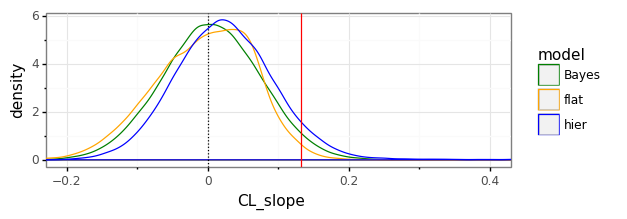

In [13]:
# Reactivation of TS (cloudy)
plot_name_base = '0TS_react_hist'

for colname in [CL_cols[8]]:  # CL_cols[8:] + ['CL_slope_TS1minusTS2', 'CL_slope_TS0minusTS2', 'CL_slope_TS0minusTS1']:
    xlim = (-0.2, 0.4)
    make_histogram(all_summaries, hum_summary_cloudy, colname,
                   plot_name='{}_{}_hist.png'.format(plot_name_base, colname),
                   xlim=xlim)

#     make_diff_hist(all_summaries, hum_summary_cloudy, colname, model_names, n_bins=18,
#                    plot_name='{}_{}_diff.png'.format(plot_name_base, colname),
#                    xlim=xlim)
    
print(get_means_sds(all_summaries, hum_summary_cloudy, 'CL_slope'))
# print(get_means_sds(all_summaries, hum_summary_cloudy, 'CL_slope_TS1minusTS2'))
# print(get_means_sds(all_summaries, hum_summary_cloudy, 'CL_slope_TS0minusTS2'))
# print(get_means_sds(all_summaries, hum_summary_cloudy, 'CL_slope_TS0minusTS1'))

In [ ]:
# Intrusion errors (init. learn.)
plot_name_base = '1intrusion_errors_hist'

for colname in IL_cols[3:5]:
    xlim = (0.2, 0.5)
    make_histogram(all_summaries, hum_summary_initial_learn, colname,
                   plot_name='{}_{}_hist.png'.format(plot_name_base, colname),
                   xlim=xlim, ylim=(0, 11.5), vline=1/3)

    make_diff_hist(all_summaries, hum_summary_initial_learn, colname, model_names, n_bins=20,
                   plot_name='{}_{}_diff.png'.format(plot_name_base, colname),
                   xlim=xlim, vline=1/3)

print(get_means_sds(all_summaries, hum_summary_initial_learn, IL_cols[3], 1/3))
print(get_means_sds(all_summaries, hum_summary_initial_learn, IL_cols[4], 1/3))

In [ ]:
# TS values affect preference (competition)
plot_name_base = '3TS_values_preference_hist'

sub_dat = all_summaries.loc[all_summaries['model'] != 'Bayes']  # Remove Bayes for this analysis

# for colname in CO_cols[:2]:
#     xlim = (0.45, 0.7)
#     make_histogram(sub_dat, hum_summary_competition, colname,
#                    plot_name='{}_{}_hist.png'.format(plot_name_base, colname),
#                    xlim=xlim, vline=1/2)
    
#     make_diff_hist(sub_dat, hum_summary_competition, colname, model_names,
#                    plot_name='{}_{}_diff.png'.format(plot_name_base, colname),
#                    xlim=xlim, vline=1/2)

# colname = 'CO_season_minus_alien'
# xlim = (-0.1, 0.1)
# make_histogram(sub_dat, hum_summary_competition, colname,
#                plot_name='{}_{}_hist.png'.format(plot_name_base, colname),
#                xlim=xlim)

# make_diff_hist(sub_dat, hum_summary_competition, colname, [model_names[0],],
#                plot_name='{}_{}_diff.png'.format(plot_name_base, col_name),
#                xlim=xlim)

print(get_means_sds(all_summaries, hum_summary_competition, 'CO_acc_season'))
print(get_means_sds(all_summaries, hum_summary_competition, 'CO_acc_season_alien'))
print(get_means_sds(all_summaries, hum_summary_competition, 'CO_season_minus_alien'))

In [ ]:
# TS values affect generalization (rainbow)
plot_name_base = '2TS_rainbow'

for colname in ['TS0_minus_TS2']:  #, 'TS0_minus_TS1', 'TS1_minus_TS2']:
    xlim = (-0.02, 0.15)
    make_histogram(summary_rainbow, hum_summary_rainbow, colname,
                   plot_name='{}_{}_hist.png'.format(plot_name_base, colname),
                   xlim=xlim, ylim=(0, 30))

#     make_diff_hist(summary_rainbow, hum_summary_rainbow, colname, model_names,
#                    plot_name='{}_{}_diff.png'.format(plot_name_base, colname), xlim=xlim)
    
colname = 'None'
make_histogram(summary_rainbow, hum_summary_rainbow, colname,
               plot_name='{}_{}_hist.png'.format(plot_name_base, colname),
               xlim=(0.08, 0.164), ylim=(0, 70))
    
print(get_means_sds(summary_rainbow, hum_summary_rainbow, 'None'))
print(get_means_sds(summary_rainbow, hum_summary_rainbow, 'TS0_minus_TS2'))
# print(get_means_sds(summary_rainbow, hum_summary_rainbow, 'TS0_minus_TS1'))
# print(get_means_sds(summary_rainbow, hum_summary_rainbow, 'TS1_minus_TS2'))

In [ ]:
plot_name_base = '4TS_values'
for colname in ['IL_first_TS0_minus_TS2', 'IL_first_TS0_minus_TS1', 'IL_first_TS1_minus_TS2']:
    xlim = (-0.01, 0.15)
    make_histogram(all_summaries, hum_summary_initial_learn, colname,
                   plot_name='{}_{}_hist.png'.format(plot_name_base, colname),
                   xlim=xlim)
    
    make_diff_hist(all_summaries, hum_summary_initial_learn, colname, model_names, n_bins=15,
                   plot_name='{}_{}_diff.png'.format(plot_name_base, colname),
                   xlim=xlim)

In [ ]:
plot_name_base = '5TS_values'
for colname in ['CL_first_TS0_minus_TS2', 'CL_first_TS0_minus_TS1', 'CL_first_TS1_minus_TS2']:
    xlim = (-0.01, 0.15)
    make_histogram(all_summaries, hum_summary_cloudy, colname,
                   plot_name='{}_{}_hist.png'.format(plot_name_base, colname),
                   xlim=xlim)
    
    make_diff_hist(all_summaries, hum_summary_cloudy, colname, model_names, n_bins=15,
                   plot_name='{}_{}_diff.png'.format(plot_name_base, colname),
                   xlim=xlim)

In [ ]:
# TS values affect generalization (rainbow)
fig, axes = plt.subplots(nrows=len(models), figsize=(8, 8))
colors = sns.cubehelix_palette(4, start=.5, rot=-.75, reverse=True)[:-1]

for i, model in enumerate(models):
    dat = summary_rainbow.loc[summary_rainbow['model'] == model]

    # Plot
    for j, effect in enumerate(RB_sum_cols[:3]):
        sns.distplot(dat[effect], kde=True, hist=False, label=effect, color=colors[j], ax=axes[i])
        [ax.axvline(x=10/12/3, color='grey', linestyle='--') for ax in axes[:2]]
        [ax.set_xlim(0, 0.5) for ax in axes[:2]]
        [ax.set_ylim(0, 100) for ax in axes[:2]]
        axes[i].set_title(model)
        [ax.set_xlabel("") for ax in axes]
        axes[i].legend()

[ax.set_ylabel("Density") for ax in axes]
plt.tight_layout()
plt.savefig(plot_save_dir + '/4TS_values_generalization_hist2.png')
# get_means_sds(summary_rainbow, hum_summary_rainbow, 'TS0_minus_TS2')

In [ ]:
# Rainbow phase TS choices
plt.figure()
for model in models:

    # Get summary_rainbow
    rainbow_dat = all_summaries.loc[all_summaries['model'] == model, RB_cols]
    rainbow_dat = rainbow_dat.values.reshape((rainbow_dat.shape[0], n_aliens, n_actions))
    summary_rainbow = np.array([get_summary_rainbow(n_aliens, n_seasons, dat, task) for dat in rainbow_dat])
    summary_rainbow = pd.DataFrame(summary_rainbow, columns=RB_sum_cols)
    summary_rainbow['TS0_minus_TS2'] = summary_rainbow['TS0'] - summary_rainbow['TS2']

    # Plot
    for i, effect in enumerate(RB_sum_cols[:3]):
        plt.subplot(2, 3, i+1)
        sns.distplot(summary_rainbow[effect], kde=True, hist=True, label=model)
        plt.axvline(x=10/12/3, color='grey', linestyle='--')
        plt.axvline(x=hum_summary_rainbow[effect].values, color='red', linestyle='-')
        plt.xlim(0, 0.5)
        plt.ylim(0, 60)
        plt.xlabel(effect)
        plt.ylabel("Density")

    effect = RB_sum_cols[3]
    plt.subplot(2, 3, 4)
    sns.distplot(summary_rainbow[effect], kde=True, hist=True, label=model)
    plt.axvline(x=(2/12), color='grey', linestyle='--')
    plt.axvline(x=hum_summary_rainbow[effect].values, color='red', linestyle='-')
    plt.xlim(0, 0.5)
    plt.ylim(0, 60)
    plt.xlabel(effect)
    plt.ylabel("Density")

    effect = 'TS0_minus_TS2'
    plt.subplot(2, 3, 5)
    sns.distplot(summary_rainbow[effect], kde=True, hist=True, label=model)
    plt.axvline(x=0, color='grey', linestyle='--')
    plt.axvline(x=hum_summary_rainbow[effect].values, color='red', linestyle='-')
    plt.xlim(-0.3, 0.3)
    plt.ylim(0, 60)
    plt.xlabel(effect)
    plt.ylabel("Density")

plt.legend()
plt.tight_layout()

In [ ]:
# Savings (init. learn.)
make_histogram(all_summaries,
               hum_summary_initial_learn, IL_cols[:3] + ['IL_saving_last_minus_first'],
               plot_name='5Savings_hist.png')

In [ ]:
# Plot paramter - marker correlations
hum_sums = hum_summary_initial_learn[['IL_acc_prev_TS', 'IL_acc_current_TS']]
hum_sums['CO_acc_season'] = hum_summary_competition['CO_acc_season']
hum_sums['CO_acc_season_alien'] = hum_summary_competition['CO_acc_season_alien']
hum_sums['CL_slope'] = hum_summary_cloudy['CL_slope']
hum_sums['Qts_1InitialLearn_mean'] = hum_regr_coefs['Qts_1InitialLearn_mean']
hum_sums['Qa_1InitialLearn_mean'] = hum_regr_coefs['Qa_1InitialLearn_mean']

markers = ['IL_acc_current_TS', 'IL_acc_prev_TS', 'CO_acc_season', 'CO_acc_season_alien',
           'CL_slope', 'Qts_1InitialLearn_mean', 'Qa_1InitialLearn_mean']

for model_name in models:

    # Get param_names
    param_names, param_ranges = get_param_names_ranges(model_name)
    
    # Correlations between markers and parameters
    dat = all_summaries.loc[all_summaries['model'] == model_name]
    sns.pairplot(dat, x_vars=param_names, y_vars=markers, kind='reg',
                 plot_kws={'color': 'grey', 'fit_reg': False, 'scatter_kws': {'s': 1}})
    plt.savefig(os.path.join(plot_save_dir, 'CorrMarkerParam_{}.png'.format(model_name)))

    # Correlations between different markers
    sns.pairplot(dat, vars=markers, kind='reg',
                 plot_kws={'color': 'grey', 'fit_reg': False, 'scatter_kws': {'s': 1}},
                 diag_kind='kde', diag_kws={'color': 'grey', 'shade': True})

    # Add human data
    # plt.scatter(hum_sums)
    plt.savefig(os.path.join(plot_save_dir, 'CorrParamParam_{}.png'.format(model)))